## set up dependencies and util functions

In [1]:
import numpy as np
from dm_control import mujoco
import mediapy as media
import matplotlib.pyplot as plt

""

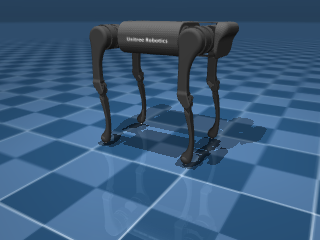

In [2]:
physics = mujoco.Physics.from_xml_path("../unitree_a1/scene.xml")
nv = physics.model.nv
nu = physics.model.nu
pixels = physics.render()
media.show_image(pixels)

In [3]:
import matplotlib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def generate_video(physics, control, start_key=None, duration=1, framerate=30):
    frames = []
    physics.reset(start_key)
    while physics.data.time < duration:
        physics.step()
        control(physics)
        if len(frames) < (physics.data.time) * framerate:
            pixels = physics.render()
            frames.append(pixels)
    return media.show_video(frames, fps=framerate)


def generate_from_qpos(physics, times, qposes, framerate=30):
    # assume times are uniform
    frames = []
    for t, qpos in zip(times, qposes):
        physics.data.qpos = qpos
        physics.data.qvel[:] = 0
        physics.step()
        pixels = physics.render()
        frames.append(pixels)
    return media.show_video(frames, fps=framerate)    

In [7]:
def simple_control(physics):
    e = (physics.model.key('home').qpos - physics.data.qpos)[7:]
    physics.data.ctrl =  e * 10

generate_video(physics, simple_control, duration=10, start_key=0)

In [8]:
conf0 = physics.model.qpos0
conf1 = conf0.copy()
conf1[0] += 1
u = np.linspace(0, 1, 100)
qpos_series = (1-u)[:, None] * conf0[None, :] + u[:, None] * conf1[None, :]

generate_from_qpos(physics, u, qpos_series)

In [46]:
joint_names = [physics.model.joint(i).name for i in range(physics.model.njnt) if physics.model.joint(i).name]
joint_ids = [physics.model.joint(name).dofadr[0] for name in joint_names]

contact_site_names = ["foot1", "foot2", "foot3", "foot4"]
contact_site_ids = [physics.model.site(name).id for name in contact_site_names]

In [55]:
physics.model.body('trunk').subtreemass
physics.model.body('trunk').inertia

mass = physics.model.body(1).subtreemass[0]
gravity = physics.model.opt.gravity

In [48]:
import casadi as ca
from copy import deepcopy

# this makes the dynamics super slow!
# lets change this in the future...

class _MyMassMatrix(ca.Callback):
    def __init__(self, physics):
        self.physics = deepcopy(physics)
        ca.Callback.__init__(self)
        self.construct("MyMassMatrix", {"enable_fd": True})

    def eval(self, q):
        self.physics.data.qpos = np.array(q).reshape(-1)
        self.physics.forward()
        
        nv = self.physics.model.nv
        M = np.zeros((nv, nv), dtype='float64')
        mujoco.mj_fullM(self.physics.model._model, M, self.physics.data.qM)
        return [M]
    
    def get_sparsity_out(self, i):
          if i==0:
                return ca.Sparsity.dense(self.physics.model.nv, self.physics.model.nv)

    def get_sparsity_in(self, i):
          if i==0:
                return ca.Sparsity.dense(self.physics.model.nq)


# casadi_M_func = ca.Function.load('../kino_dynamics_gen/casadi_functions/M.func')
casadi_M_func = _MyMassMatrix(physics)
# qhome = physics.model.key('home').qpos
# casadi_M_func(qhome)

## Utils

In [142]:
import casadi as ca

def quadratic_cost(vec, mat):
    return vec.transpose @ mat @ vec


def Rotation_Z_sym(alpha):
    res = ca.MX.zeros((3, 3))
    res[:, 0] = [ca.cos(alpha), ca.sin(alpha), 0]
    res[:, 1] = [ca.cos(alpha), -ca.sin(alpha), 0]
    res[:, 2] = [0, 0, 1]
    return res

In [149]:
Rotation_Z_sym(ca.MX.sym('alpha'))

NotImplementedError: Wrong number or type of arguments for overloaded function 'MX_set'.
  Possible prototypes are:
    set(self,MX,bool,Sparsity)
    set(self,MX,bool,Slice)
    set(self,MX,bool,IM)
    set(self,MX,bool,Slice,Slice)
    set(self,MX,bool,Slice,IM)
    set(self,MX,bool,IM,Slice)
    set(self,MX,bool,IM,IM)
  You have: '(MX,[int|MX],bool,slice,int)'


## First round optimization

In [144]:
# parameters. initialization

import casadi as ca

N_traj=20
physics.reset(0)
physics.forward()
com_to_feet = [
    physics.data.site(i).xpos - physics.data.body(1).subtree_com
    for i in contact_site_ids
]

init_M = casadi_M_func(physics.data.qpos)
init_I = init_M[3:6, 3:6]
inv_I = np.linalg.inv(init_I)
inv_I_z = init_I[2]

qpos_home = physics.data.qpos.copy()
qpos_dest = qpos_home.copy()
qpos_dest[0] += 3 # a simple destination. 3 units in x direction

X_ref = np.zeros((N_traj, 8))
X_ref[:, :3] = np.linspace(qpos_home[:3], qpos_dest[:3], N_traj)
X_ref[:, 4] = np.zeros(N_traj)
X_ref[1:, 4:] = X_ref[1:, :4] - X_ref[:-1, :4]

total_T = 3

dt = np.ones(N_traj-1) * total_T / (N_traj-1)

mu = 1 # or change?
mass = physics.model.body(1).subtreemass[0]
gravity = physics.model.opt.gravity

QX = np.diag([1, 1, 1, 1, 1, 1, 1, 1])
QH = np.diag([1, 1])
QF = np.diag([1, 1, 1])

In [145]:
def formulate_optimization(physics):
    opti = ca.Opti()

    X = opti.variable(N_traj, 8)
    q = X[:, :4]
    yaw = q[:, 3]
    dq = X[:, 4:]
    f_contact = [opti.variable(N_traj-1, 3) for foot in contact_site_ids]
    
    # ignore q limits and qd limits for now as we don't have them in the model    
    # initial conditions
    opti.subject_to(X[0, :] == X_ref[0, :].reshape(1, -1))
    opti.subject_to(X[-1, :] == X_ref[-1, :].reshape(1, -1))
    
    cost = ca.SX(0)
    
    for t in range(N_traj-1):
        rot = Rotation_Z_sym(yaw)

        # dynamics constraint
        ddr = sum(f_contact[t])/mass + gravity
        dh = sum([np.cross((rot @ r), fc) for r in zip(com_to_feet, f_contact[t])])
        dyaw = inv_I_z * dh[2] # todo shouldn't we do matrix multiplication here?
        opti.subject_to(q[t+1] - q[t] == dt[t] * dq[t])  # euler integration. todo improve
        opti.subject_to(dq[t+1][:3] - dq[t][:3] == dt[t] * ddr)
        opti.subject_to(dq[t+1][3] - dq[t][3] == dt[t] * dyaw)
    
        # contact forces constraint
        for i, contact_site_id in contact_site_ids:
            opti.subject_to(f_contact[i][t, 2] >= 0)
    
        # friction cone:
        for i, contact_site_id in contact_site_ids:
            x_force = f_contact[i][t, 0]
            y_force = f_contact[i][t, 1]
            z_force = f_contact[i][t, 2]
            opti.subject_to(np.sqrt(2) * x_force <= mu * z_force) # why do we have to have sqrt(2)
            opti.subject_to(np.sqrt(2) * x_force >= -mu * z_force)
            opti.subject_to(np.sqrt(2) * y_force <= mu * z_force) # why do we have to have sqrt(2)
            opti.subject_to(np.sqrt(2) * y_force >= -mu * z_force)
            
        X_err = X[t, :] - X_ref[t, :]
        cost += sum(quadratic_cost(vec=X_err, mat=QX), 
                                quadratic_cost(vec=dh[:2], mat=QH),
                                *[quadratic_cost(vec=f_contact[i], mat=QF) for i, contact_id in enumerate(contact_site_ids)])
        
    f_contact = [opti.variable(N_traj-1, 3) for foot in contact_site_ids]
    opti.minimize(cost)
    
    return opti

In [146]:
opti = formulate_optimization(physics)


NotImplementedError: Wrong number or type of arguments for overloaded function 'MX_set'.
  Possible prototypes are:
    set(self,MX,bool,Sparsity)
    set(self,MX,bool,Slice)
    set(self,MX,bool,IM)
    set(self,MX,bool,Slice,Slice)
    set(self,MX,bool,Slice,IM)
    set(self,MX,bool,IM,Slice)
    set(self,MX,bool,IM,IM)
  You have: '(MX,[int|MX],bool,slice,int)'
